In [26]:
import pandas as pd
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import Lasso
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze

In [27]:
# None-image features
data = getDataPandas()

In [41]:
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

In [35]:
# Tasks include models used
TASKS = [
    #'classification/5',
    #'regression',
    'classification/2',
    #'xgboost/2'
]
# Features include image features used
FEATURES = [
    ['t1_radiomic'],
]

In [30]:
# Maybe write to a specific file later?
log_func = print

In [31]:
rst = {}

In [32]:
from mrmr import mrmr_classif, mrmr_regression

Current Task: classification/2

Image Features:
 ['t1_radiomic']

SEX chi2 p: 0.5414803876006902
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


Selected features: ['lCAU_original_firstorder_Maximum' 'rCAU_original_firstorder_Range'
 'lSN_original_glcm_ClusterProminence'
 'rSN_original_glcm_ClusterProminence'
 'rCAU_original_glszm_SizeZoneNonUniformity'
 'rTHA_original_glszm_GrayLevelNonUniformity'
 'lTHA_original_glrlm_GrayLevelNonUniformity'
 'lPUT_original_gldm_SmallDependenceHighGrayLevelEmphasis'
 'lSN_original_glrlm_LongRunHighGrayLevelEmphasis'
 'lCAU_original_glszm_SizeZoneNonUniformity'
 'lTHA_original_gldm_SmallDependenceHighGrayLevelEmphasis'
 'rTHA_original_glszm_LargeAreaHighGrayLevelEmphasis'
 'rTHA_original_gldm_SmallDependenceHighGrayLevelEmphasis'
 'rPUT_original_gldm_SmallDependenceHighGrayLevelEmphasis'
 'lCAU_original_glcm_ClusterShade'
 'rTHA_original_glszm_SizeZoneNonUniformity']

Demo + Clinic:

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Model: svc
AUC train 0.7322908313285218, test 0.7329545454545455


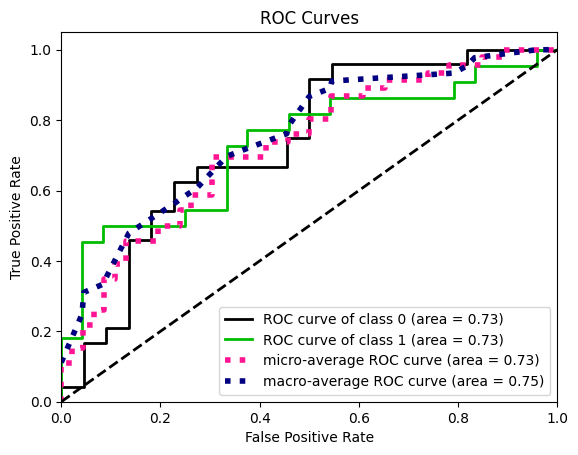

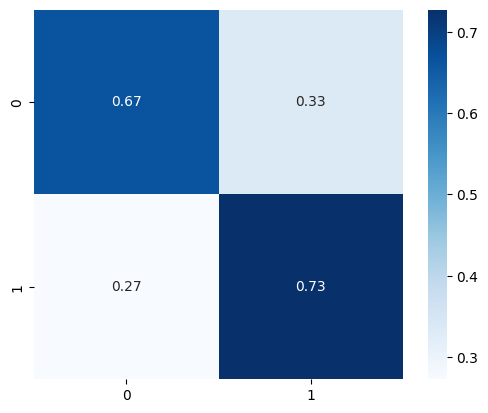

Params {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 1e-10}

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Model: xgboost
AUC train 0.9662523389468057, test 0.7462121212121212


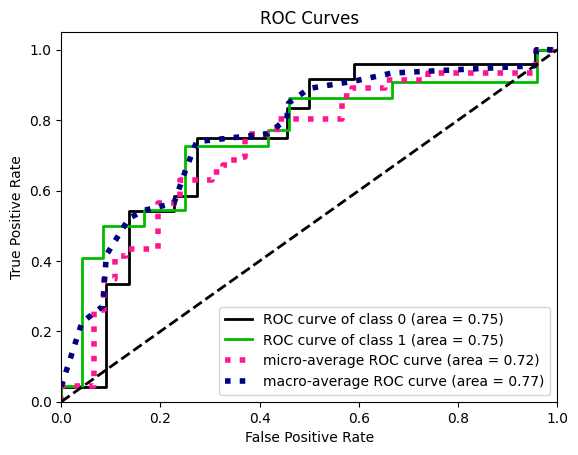

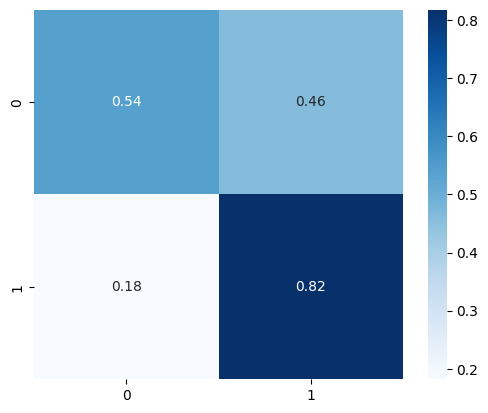

Params {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'missing': -999, 'n_estimators': 25, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.85}


Demo + Clinic + Img:

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Model: svc
AUC train 0.7626303127506016, test 0.6931818181818181


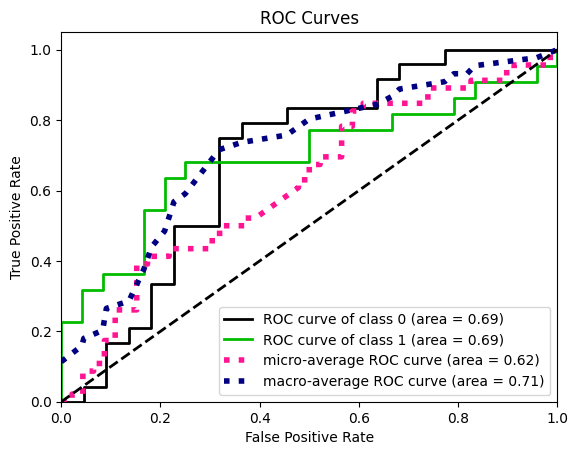

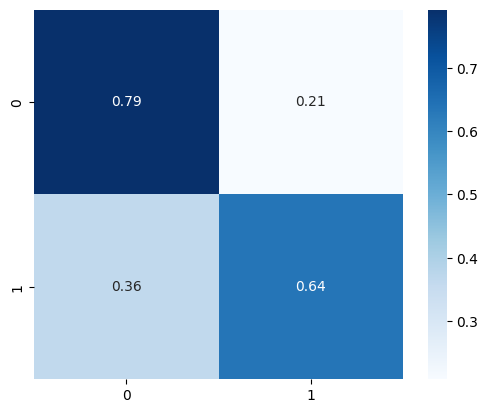

Params {'C': 100, 'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 1e-10}

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Model: xgboost
AUC train 1.0, test 0.6590909090909092


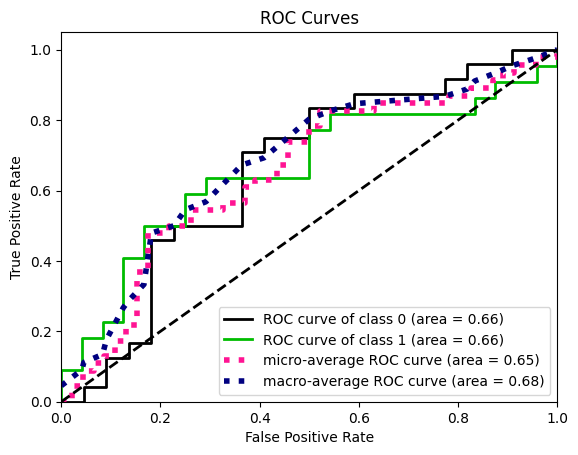

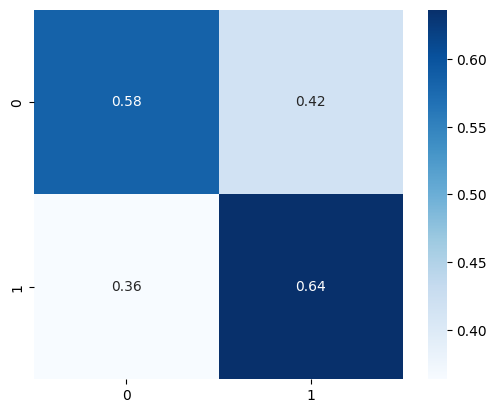

Params {'colsample_bytree': 0.75, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.8}




In [45]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test = x_img_test.join(x_fe_test.reset_index(drop=True))

        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        #mRMR
        selected = mrmr_classif(X=x_img_train, y=y_train, K=100) if not isContinuous else mrmr_regression(X=x_img_train, y=y_train, K=50)
        #LASSO for classification?
        la = Lasso(alpha=0.1)
        la.fit(x_img_train[selected], data['SCORE'].iloc[train_inds])
        selected = np.array(selected)[np.abs(la.coef_)>0]
        #selected = selected[:10]
        log_func('Selected features: {}'.format(selected))
        log_func()
        x_img_train = x_img_train[selected]
        x_img_test = x_img_test[selected]

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Clinic + Img:']

        # Loop
        for i in range(2):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]()
                cv = GridSearchCV(
                    model,
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring'],
                    verbose = 1
                )
                cv.fit(x_train, y_train.values.ravel())
                best = cv.best_estimator_
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = best.predict_proba if metric[1] else best.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    # TODO: multiclass support should be implemented via metric_func
                    log_func('{} train {}, test {}'.format(metric[0],
                                                           metric_func(y_train[task['output']].to_numpy(), train_pred),
                                                           metric_func(y_test[task['output']].to_numpy(), test_pred)
                                                           ))
                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = best.predict_proba if plot[1] else best.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
                log_func('Params {}'.format(cv.best_params_)) # best.get_params()
                log_func()
            log_func()

In [38]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset
        train_inds = data_config['train_index']
        test_inds = data_config['test_index']
        x_clinic_train = x.iloc[train_inds].reset_index(drop=True)
        x_clinic_test = x.iloc[test_inds].reset_index(drop=True)
        y_train = y.iloc[train_inds].reset_index(drop=True)
        y_test = y.iloc[test_inds].reset_index(drop=True)
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, train_inds, test_inds, params)
            x_img_train_full = x_img_train.join(x_fe_train.reset_index(drop=True))
            x_img_test_full = x_img_test.join(x_fe_test.reset_index(drop=True))

        ## Feature Selection
        ## WIP
        
        isContinuous = task['continuous']
        
        #mRMR
        ranked = mrmr_classif(X=x_img_train_full, y=y_train, K=50) if not isContinuous else mrmr_regression(X=x_img_train_full, y=y_train, K=50)
        
        rst_auc = [[[], []], [[], []]]
        
        for s in range(50):
            log_func(s)
            selected = ranked[:s]
            log_func('Selected features: {}'.format(selected))
            log_func()
            x_img_train = x_img_train_full[selected]
            x_img_test = x_img_test_full[selected]

            # Rearrange data
            # demo + clinic, demo + img, demo + clinic + img
            x_clinic_train = x_clinic_train.reset_index(drop=True)
            x_clinic_test = x_clinic_test.reset_index(drop=True)
            x_demo_train = x_clinic_train[group['demo']]
            x_demo_test = x_clinic_test[group['demo']]
            x_clinic_img_train = x_clinic_train.join(x_img_train)
            x_clinic_img_test = x_clinic_test.join(x_img_test)
            # No demo data in img df
            x_img_train = x_demo_train.join(x_img_train)
            x_img_test = x_demo_test.join(x_img_test)

            x_train_list = [x_clinic_img_train]
            x_test_list = [x_clinic_img_test]
            info_list = ['Demo + Clinic + Img:']

            # Loop
            for i in range(1):
                x_train = x_train_list[i]
                x_test = x_test_list[i]
                log_func(info_list[i])
                log_func()
                count = 0
                for model in models:
                    name = model['name']
                    parameters = model['params']
                    model = Model_LUT[name]()
                    cv = GridSearchCV(
                        model,
                        parameters,
                        n_jobs=5,
                        # StratifiedGroupKFold?
                        cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                        scoring=task['gridsearch_params']['scoring']
                    )
                    cv.fit(x_train, y_train.values.ravel())
                    best = cv.best_estimator_
                    log_func('Model: {}'.format(name))
                    # Now classification specific, other metrics need to be considered according to task
                    for metric in metric_list:
                        metric_func = Metrics_LUT[metric[0]]
                        # predict_proba True
                        # predic        False
                        pred_func = best.predict_proba if metric[1] else best.predict
                        train_pred = pred_func(x_train)
                        test_pred = pred_func(x_test)
                        # TODO: multiclass support should be implemented via metric_func
                        log_func('{} train {}, test {}'.format(metric[0],
                                                               metric_func(y_train[task['output']].to_numpy(), train_pred),
                                                               metric_func(y_test[task['output']].to_numpy(), test_pred)
                                                               ))
                        rst_auc[count][0].append(metric_func(y_train[task['output']].to_numpy(), train_pred))
                        rst_auc[count][1].append(metric_func(y_test[task['output']].to_numpy(), test_pred))
                    count += 1

Current Task: classification/2

Image Features:
 ['t1_radiomic']

SEX chi2 p: 0.5414803876006902
CAT chi2 p: 0.9510706628888684
AGE_AT_VISIT Normaltest p_train: [0.07505303], p_test: [0.48389882]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([1.54953415]), pvalue=array([0.12271054]))
NUPDR3OF Normaltest p_train: [0.01407325], p_test: [0.53859285]
NUPDR3OF ranksums p: RanksumsResult(statistic=array([0.53408144]), pvalue=array([0.59328519]))
LEDD Normaltest p_train: [2.56158925e-12], p_test: [0.1798008]
LEDD ranksums p: RanksumsResult(statistic=array([0.51837316]), pvalue=array([0.60419794]))
DURATION Normaltest p_train: [0.00553476], p_test: [0.13860719]
DURATION ranksums p: RanksumsResult(statistic=array([-0.45554005]), pvalue=array([0.64872076]))



100%|██████████| 50/50 [00:02<00:00, 20.85it/s]


0
Selected features: []

Demo + Clinic + Img:

Model: svc
AUC train 0.6729484095161722, test 0.6704545454545454
Model: xgboost
AUC train 0.9662523389468057, test 0.7462121212121212
1
Selected features: ['rCAU_original_glszm_LargeAreaLowGrayLevelEmphasis']

Demo + Clinic + Img:

Model: svc
AUC train 0.6729484095161722, test 0.6704545454545454
Model: xgboost
AUC train 0.9560278000534617, test 0.7859848484848485
2
Selected features: ['rCAU_original_glszm_LargeAreaLowGrayLevelEmphasis', 'lCAU_original_firstorder_Maximum']

Demo + Clinic + Img:

Model: svc
AUC train 0.6726811013098103, test 0.6704545454545454
Model: xgboost
AUC train 1.0, test 0.7840909090909092
3
Selected features: ['rCAU_original_glszm_LargeAreaLowGrayLevelEmphasis', 'lCAU_original_firstorder_Maximum', 'lSN_original_firstorder_RootMeanSquared']

Demo + Clinic + Img:

Model: svc
AUC train 0.6727479283614007, test 0.6723484848484849


exception calling callback for <Future at 0x7f9c7c2f1720 state=finished returned list>
Traceback (most recent call last):
  File "/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-pa

KeyboardInterrupt: 

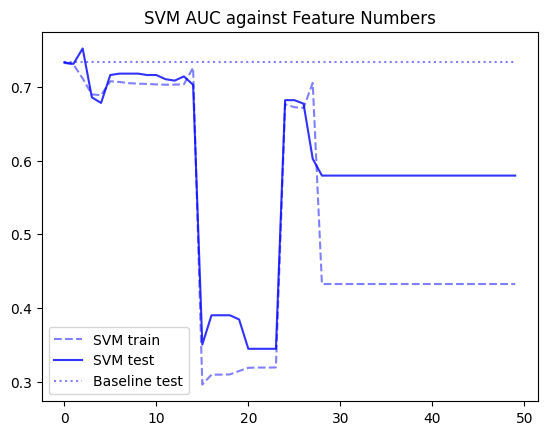

2


In [17]:
plt.plot(rst_auc[0][0], 'b--', alpha=0.5)
plt.plot(rst_auc[0][1], 'b', alpha=0.8)
plt.plot([rst_auc[0][1][0]] * 50, 'b:', alpha=0.5)
plt.legend(['SVM train', 'SVM test', 'Baseline test'])
plt.title('SVM AUC against Feature Numbers')
plt.show()
print(np.argmax(rst_auc[0][1]))

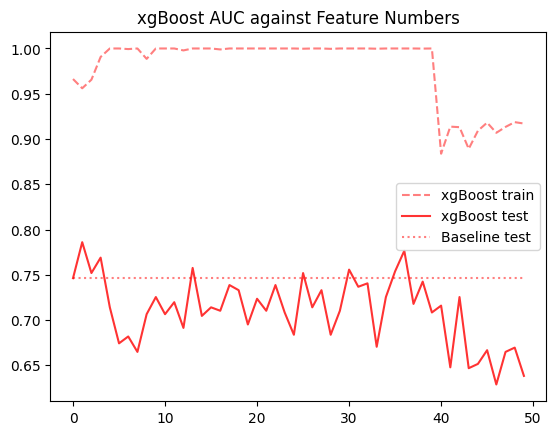

1


In [18]:
plt.plot(rst_auc[1][0], 'r--', alpha=0.5)
plt.plot(rst_auc[1][1], 'r', alpha=0.8)
plt.plot([rst_auc[1][1][0]] * 50, 'r:', alpha=0.5)
plt.legend(['xgBoost train', 'xgBoost test', 'Baseline test'])
plt.title('xgBoost AUC against Feature Numbers')
plt.show()
print(np.argmax(rst_auc[1][1]))

In [12]:
rst_auc[1][1][3]

0.768939393939394